In [8]:
import skimage
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [9]:
file = '../data/raw/9_R3D_D3D_3D_MERGED.tiff'
img = tifffile.imread(file)
img = np.moveaxis(img, 0, 1)
img = img[0,:,:,:]

print(img.shape)

(55, 1024, 1024)


In [10]:
def display(im3d, cmap="gray", step=2):
    _, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 18))

    vmin = im3d.min()
    vmax = im3d.max()

    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])

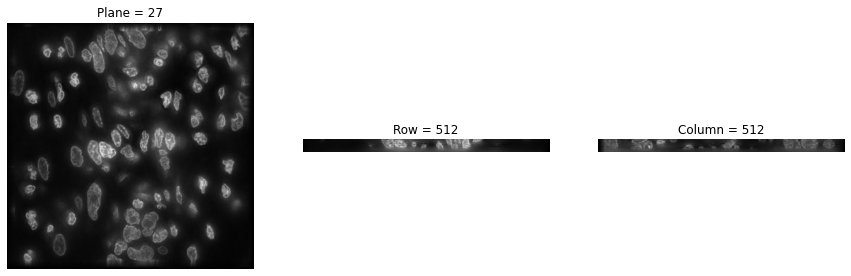

In [11]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)

(n_plane, n_row, n_col) = img.shape
_, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

show_plane(a, img[n_plane // 2], title=f'Plane = {n_plane // 2}')
show_plane(b, img[:, n_row // 2, :], title=f'Row = {n_row // 2}')
show_plane(c, img[:, :, n_col // 2], title=f'Column = {n_col // 2}')

In [12]:
def slice_in_3D(ax, i):
    # From https://stackoverflow.com/questions/44881885/python-draw-3d-cube
    Z = np.array([[0, 0, 0],
                  [1, 0, 0],
                  [1, 1, 0],
                  [0, 1, 0],
                  [0, 0, 1],
                  [1, 0, 1],
                  [1, 1, 1],
                  [0, 1, 1]])

    Z = Z * img.shape
    r = [-1, 1]
    X, Y = np.meshgrid(r, r)

    # Plot vertices
    ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

    # List sides' polygons of figure
    verts = [[Z[0], Z[1], Z[2], Z[3]],
             [Z[4], Z[5], Z[6], Z[7]],
             [Z[0], Z[1], Z[5], Z[4]],
             [Z[2], Z[3], Z[7], Z[6]],
             [Z[1], Z[2], Z[6], Z[5]],
             [Z[4], Z[7], Z[3], Z[0]],
             [Z[2], Z[3], Z[7], Z[6]]]

    # Plot sides
    ax.add_collection3d(
        Poly3DCollection(
            verts,
            facecolors=(0, 1, 1, 0.25),
            linewidths=1,
            edgecolors="darkblue"
        )
    )

    verts = np.array([[[0, 0, 0],
                       [0, 0, 1],
                       [0, 1, 1],
                       [0, 1, 0]]])
    verts = verts * (60, 256, 256)
    verts += [i, 0, 0]

    ax.add_collection3d(
        Poly3DCollection(
            verts,
            facecolors="magenta",
            linewidths=1,
            edgecolors="black"
        )
    )

    ax.set_xlabel("plane")
    ax.set_xlim(0, 100)
    ax.set_ylabel("row")
    ax.set_zlabel("col")

    # Autoscale plot axes
    scaling = np.array([getattr(ax,
                                f'get_{dim}lim')() for dim in "xyz"])
    ax.auto_scale_xyz(* [[np.min(scaling), np.max(scaling)]] * 3)


def explore_slices(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data)

    @interact(plane=(0, N - 1))
    def display_slice(plane=42):
        fig, ax = plt.subplots(figsize=(20, 5))

        ax_3D = fig.add_subplot(133, projection="3d")

        show_plane(ax, data[plane], title=f'Plane {plane}', cmap=cmap)
        slice_in_3D(ax_3D, plane)

        plt.show()

    return display_slice

In [13]:
explore_slices(img)

interactive(children=(IntSlider(value=42, description='plane', max=54), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=42)>

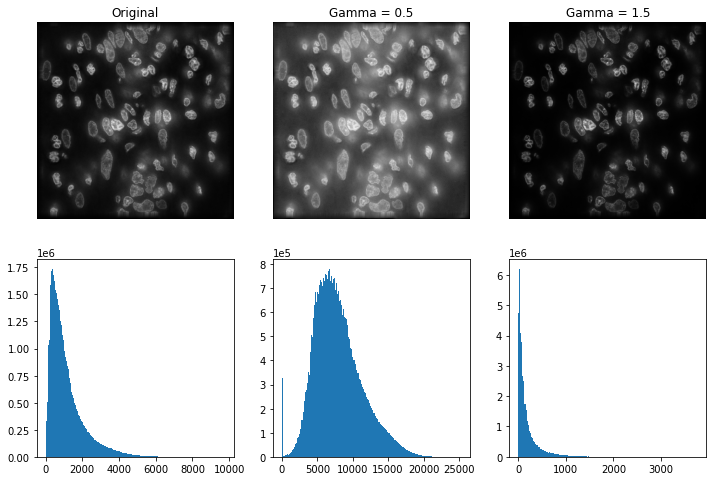

In [14]:
def plot_hist(ax, data, title=None):
    # Helper function for plotting histograms
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    if title:
        ax.set_title(title)


gamma_low_val = 0.5
gamma_low = skimage.exposure.adjust_gamma(img, gamma=gamma_low_val)

gamma_high_val = 1.5
gamma_high = skimage.exposure.adjust_gamma(img, gamma=gamma_high_val)

_, ((a, b, c), (d, e, f)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

show_plane(a, img[32], title='Original')
show_plane(b, gamma_low[32], title=f'Gamma = {gamma_low_val}')
show_plane(c, gamma_high[32], title=f'Gamma = {gamma_high_val}')

plot_hist(d, img)
plot_hist(e, gamma_low)
plot_hist(f, gamma_high)

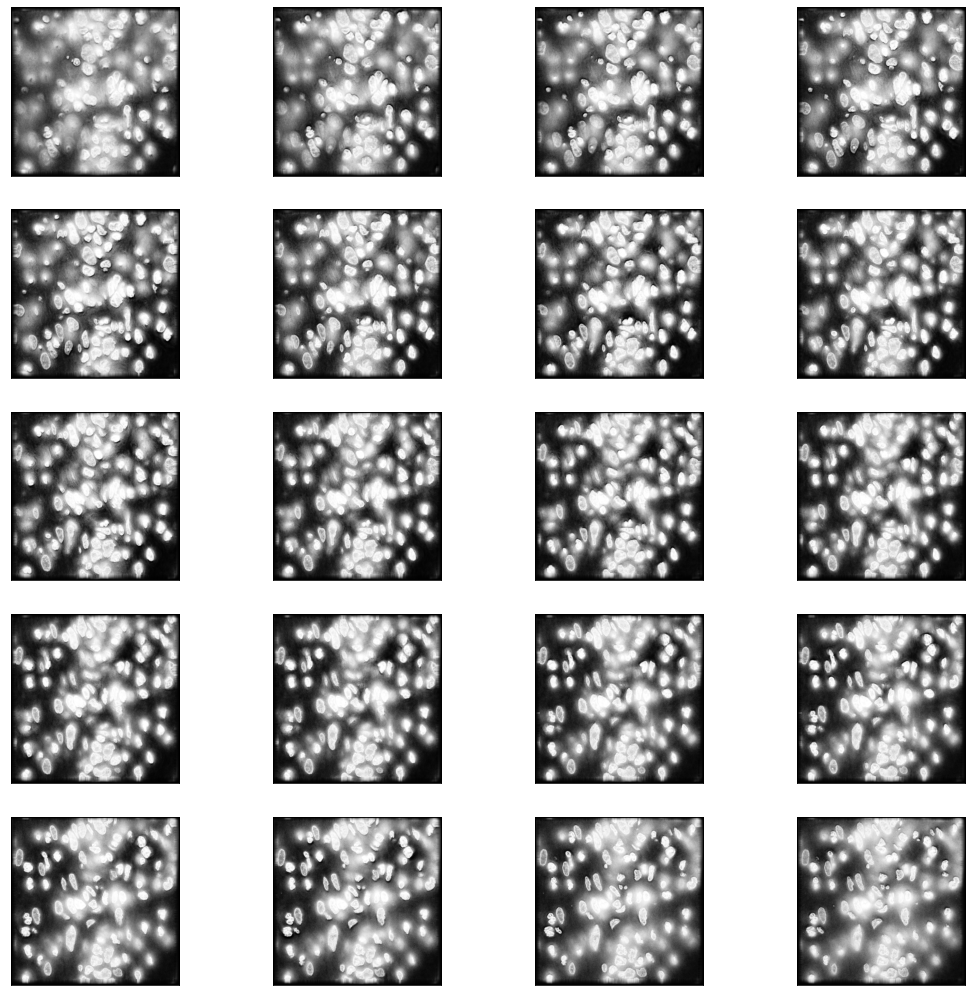

In [15]:
equalized_data = skimage.exposure.equalize_hist(img)

display(equalized_data)

Text(0.5, 1.0, 'Histogram equalization CDF')

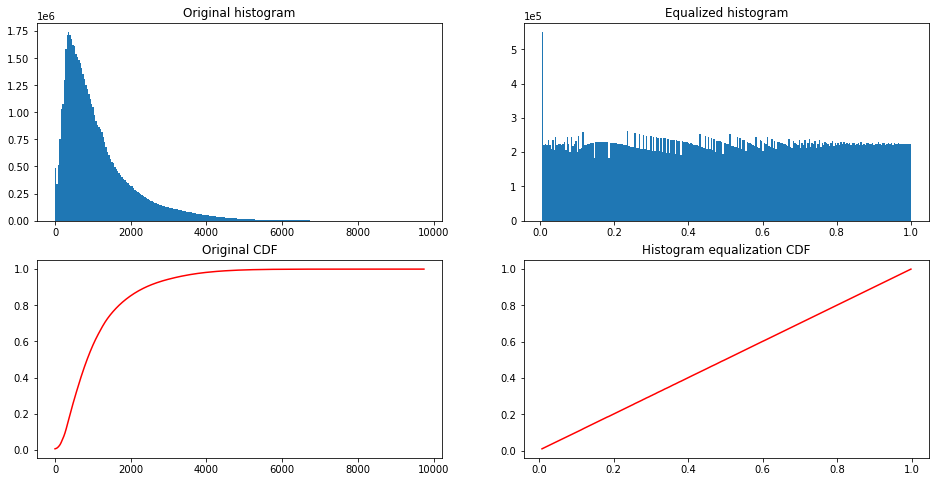

In [16]:
_, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

plot_hist(a, img, title="Original histogram")
plot_hist(b, equalized_data, title="Equalized histogram")

cdf, bins = skimage.exposure.cumulative_distribution(img.ravel())
c.plot(bins, cdf, "r")
c.set_title("Original CDF")

cdf, bins = skimage.exposure.cumulative_distribution(equalized_data.ravel())
d.plot(bins, cdf, "r")
d.set_title("Histogram equalization CDF")

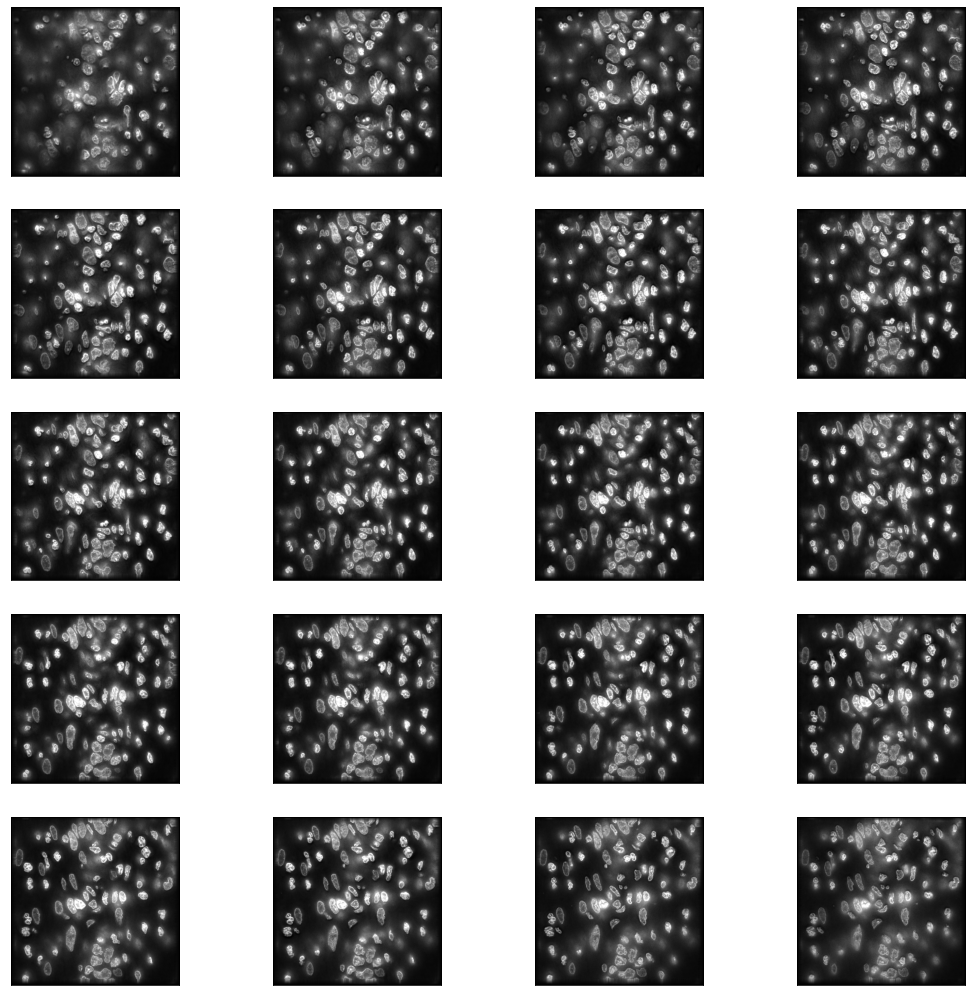

In [17]:
vmin, vmax = np.percentile(img, q=(0.5, 99.5))

clipped_data = skimage.exposure.rescale_intensity(
    img,
    in_range=(vmin, vmax),
    out_range=np.float32
)

display(clipped_data)

In [72]:
with h5py.File('../data/raw/9_R3D_D3D_3D_MERGED.h5', 'w') as f:
    f.create_dataset('data', data=clipped_data)

In [28]:
with h5py.File('../data/seg.h5', 'r') as f:
    imgs = f['exported_data'][:]
    imgs = imgs.squeeze()
    print(imgs.shape)
    print(clipped_data.shape)
    clipped_data[imgs == 2] = 0


with h5py.File('../data/9_better.h5', 'w') as f:
    f.create_dataset("img", data=clipped_data)

(55, 1024, 1024)
(55, 1024, 1024)


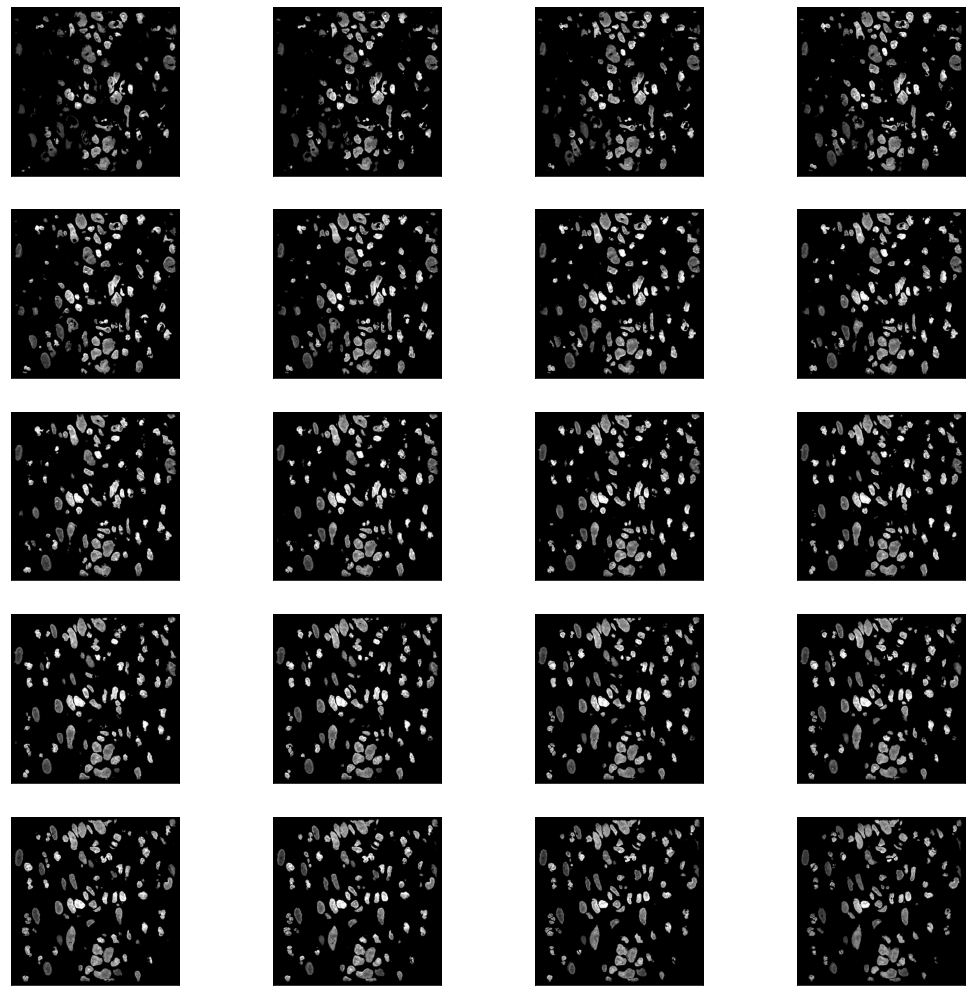

In [22]:
display(clipped_data)

In [26]:
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

clipped_data=clipped_data.astype(np.int64)

distance = ndi.distance_transform_edt(clipped_data)
coords = peak_local_max(distance, labels=clipped_data)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=clipped_data)


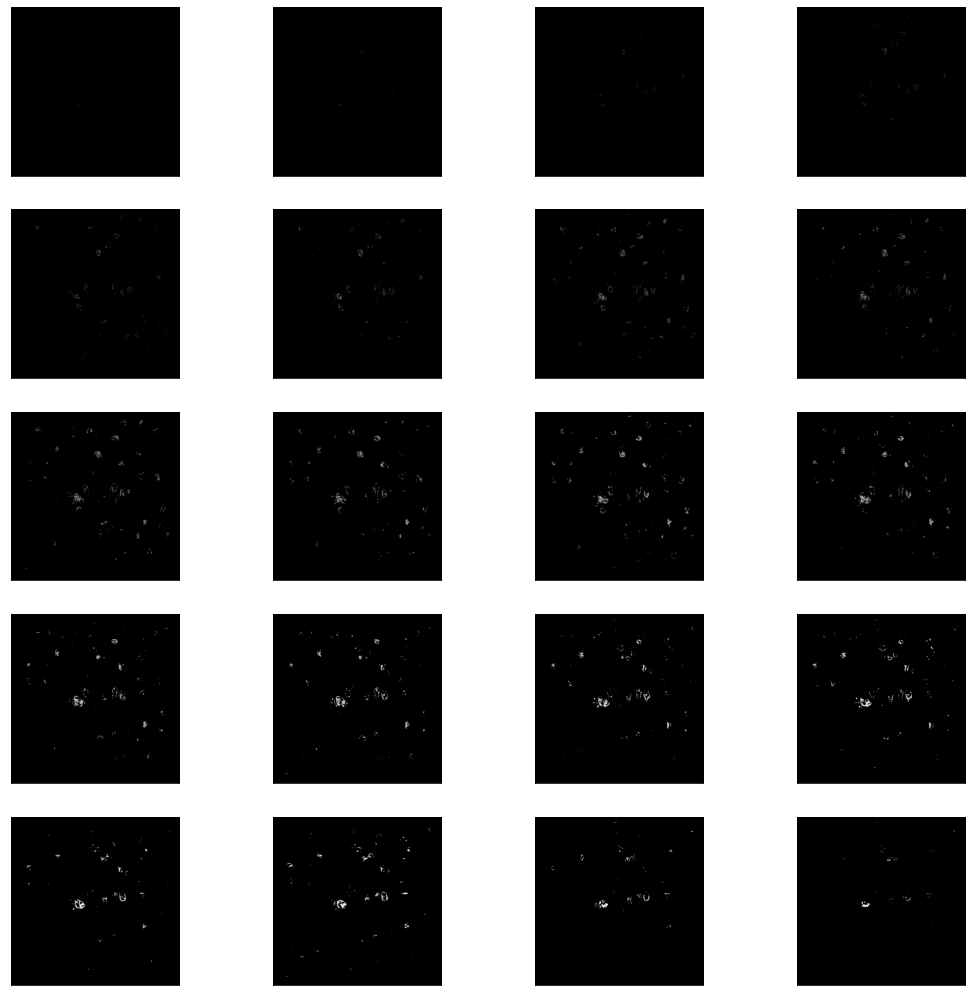

In [27]:
display(labels)

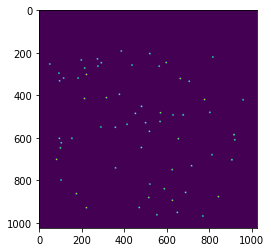

In [32]:
with h5py.File('../data/centers.h5', 'r') as hf:

    centers = hf['exported_data'][:].squeeze()
    plt.imshow(centers[33])